# Projeção do Covid-19 no Brasil 
> Projeção do número de casos e número de mortes no Brasil para a próxima semana. Gráficos com casos e óbitos novos.

- toc: false
- branch: master
- badges: false
- comments: true
- author: Fernando Wittmann & Vinicius Bastos Gomes
- categories: [coronavirus]

## Gráficos
### Projeção do número de casos no Brasil para a próxima semana




In [75]:
#hide
!sudo apt-get install imagemagick

Reading package lists... Done
Building dependency tree       
Reading state information... Done
imagemagick is already the newest version (8:6.9.7.4+dfsg-16ubuntu6.8).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


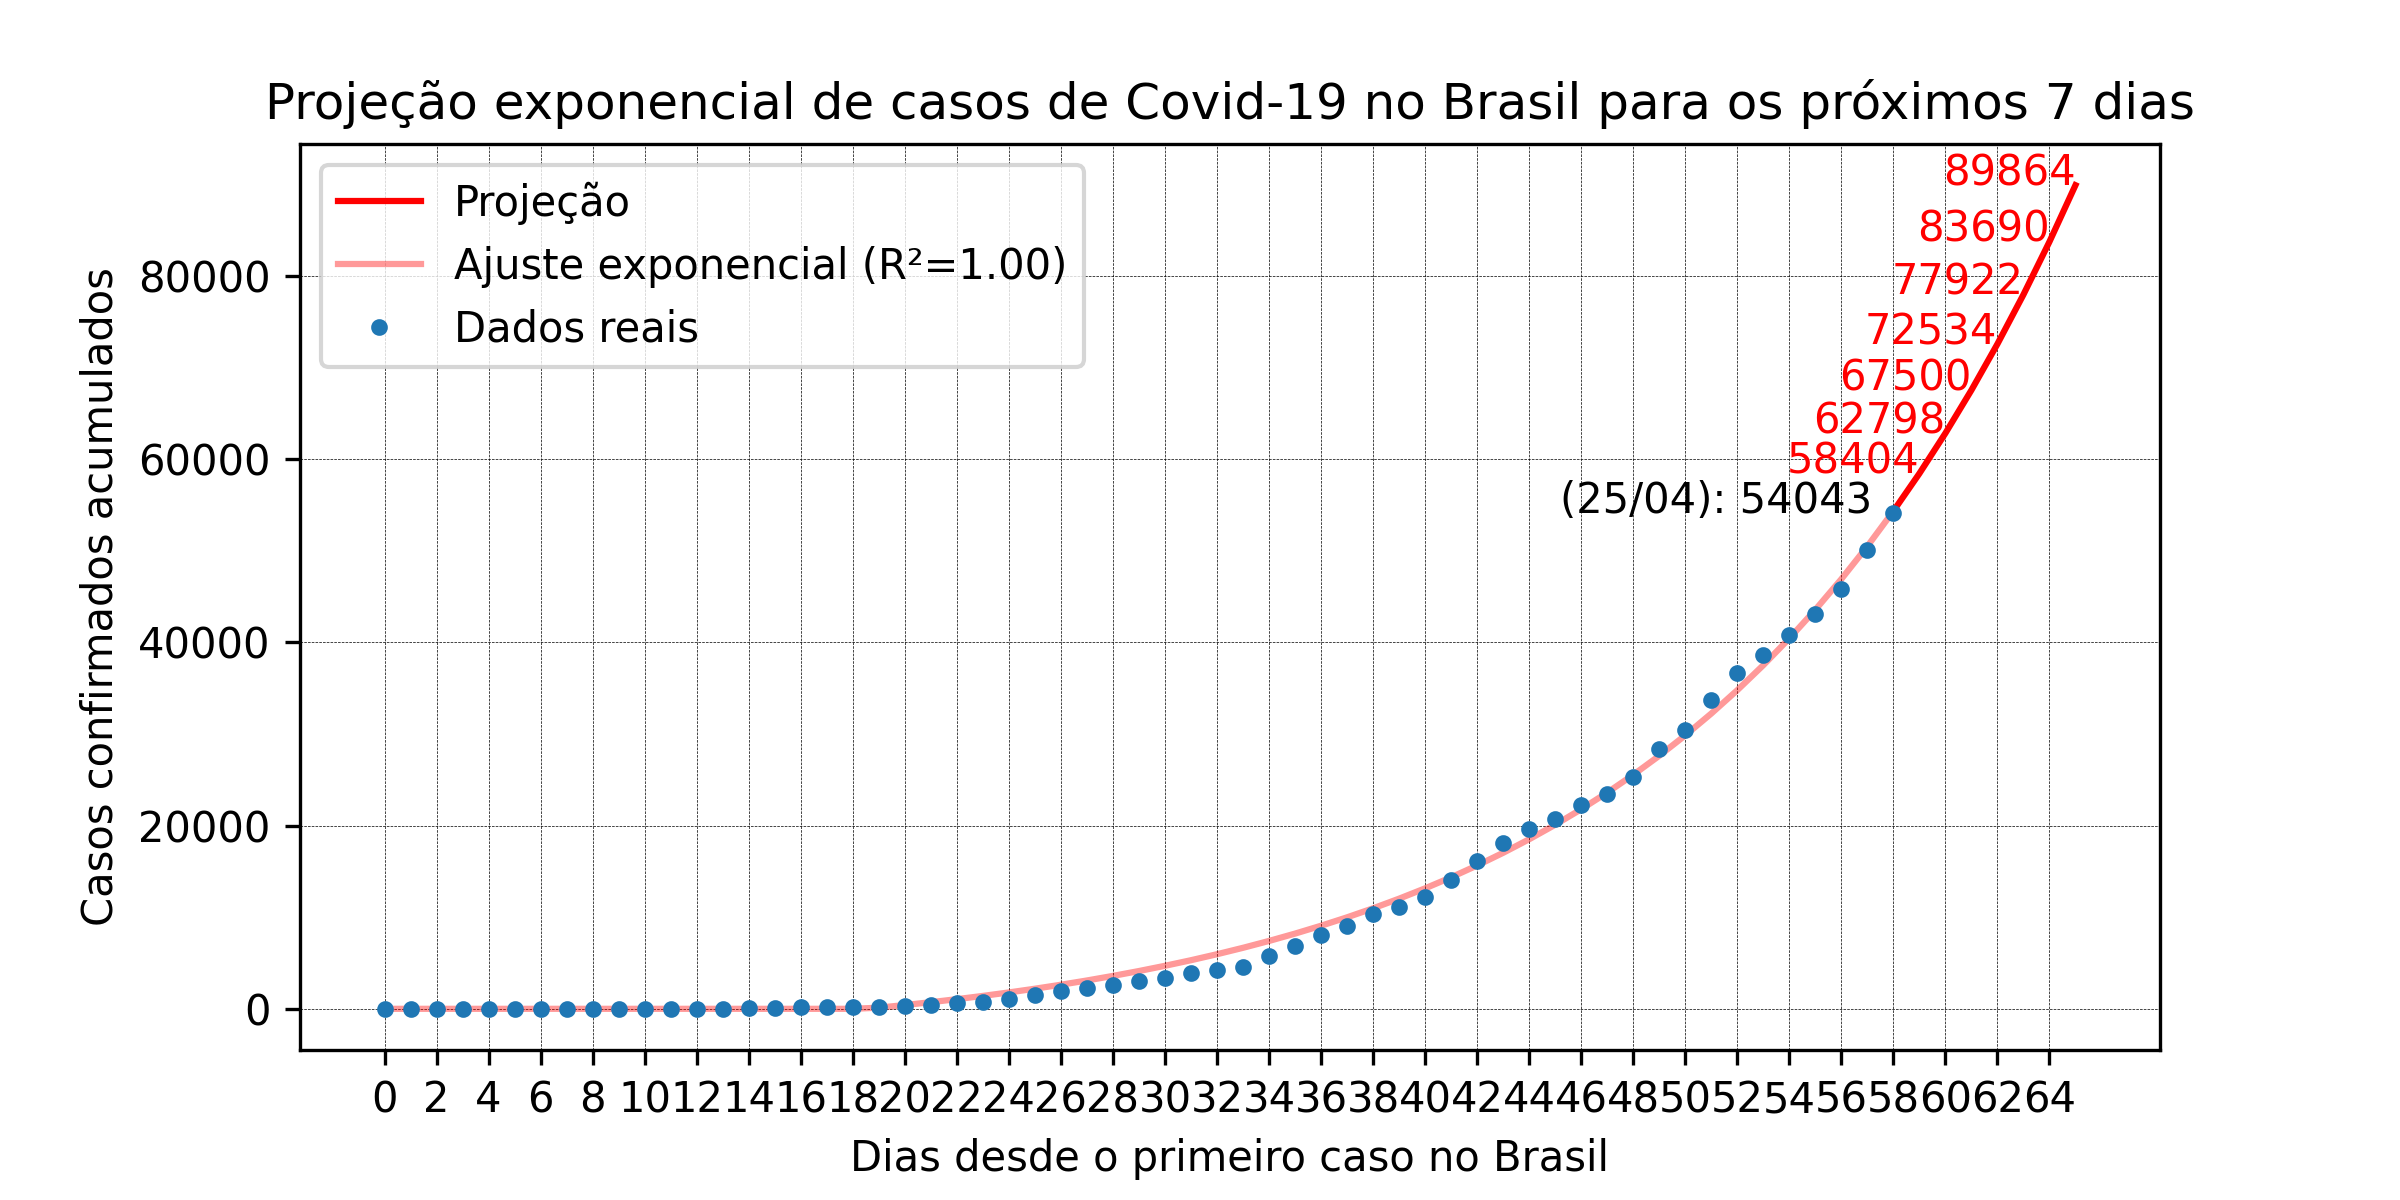

In [76]:
#hide_input
from IPython.display import Image, display
try:
    display(Image('projecao_exponencial_casos_7_dias.png'))
except:
    pass

### Projeção do número de óbitos no Brasil para a próxima semana

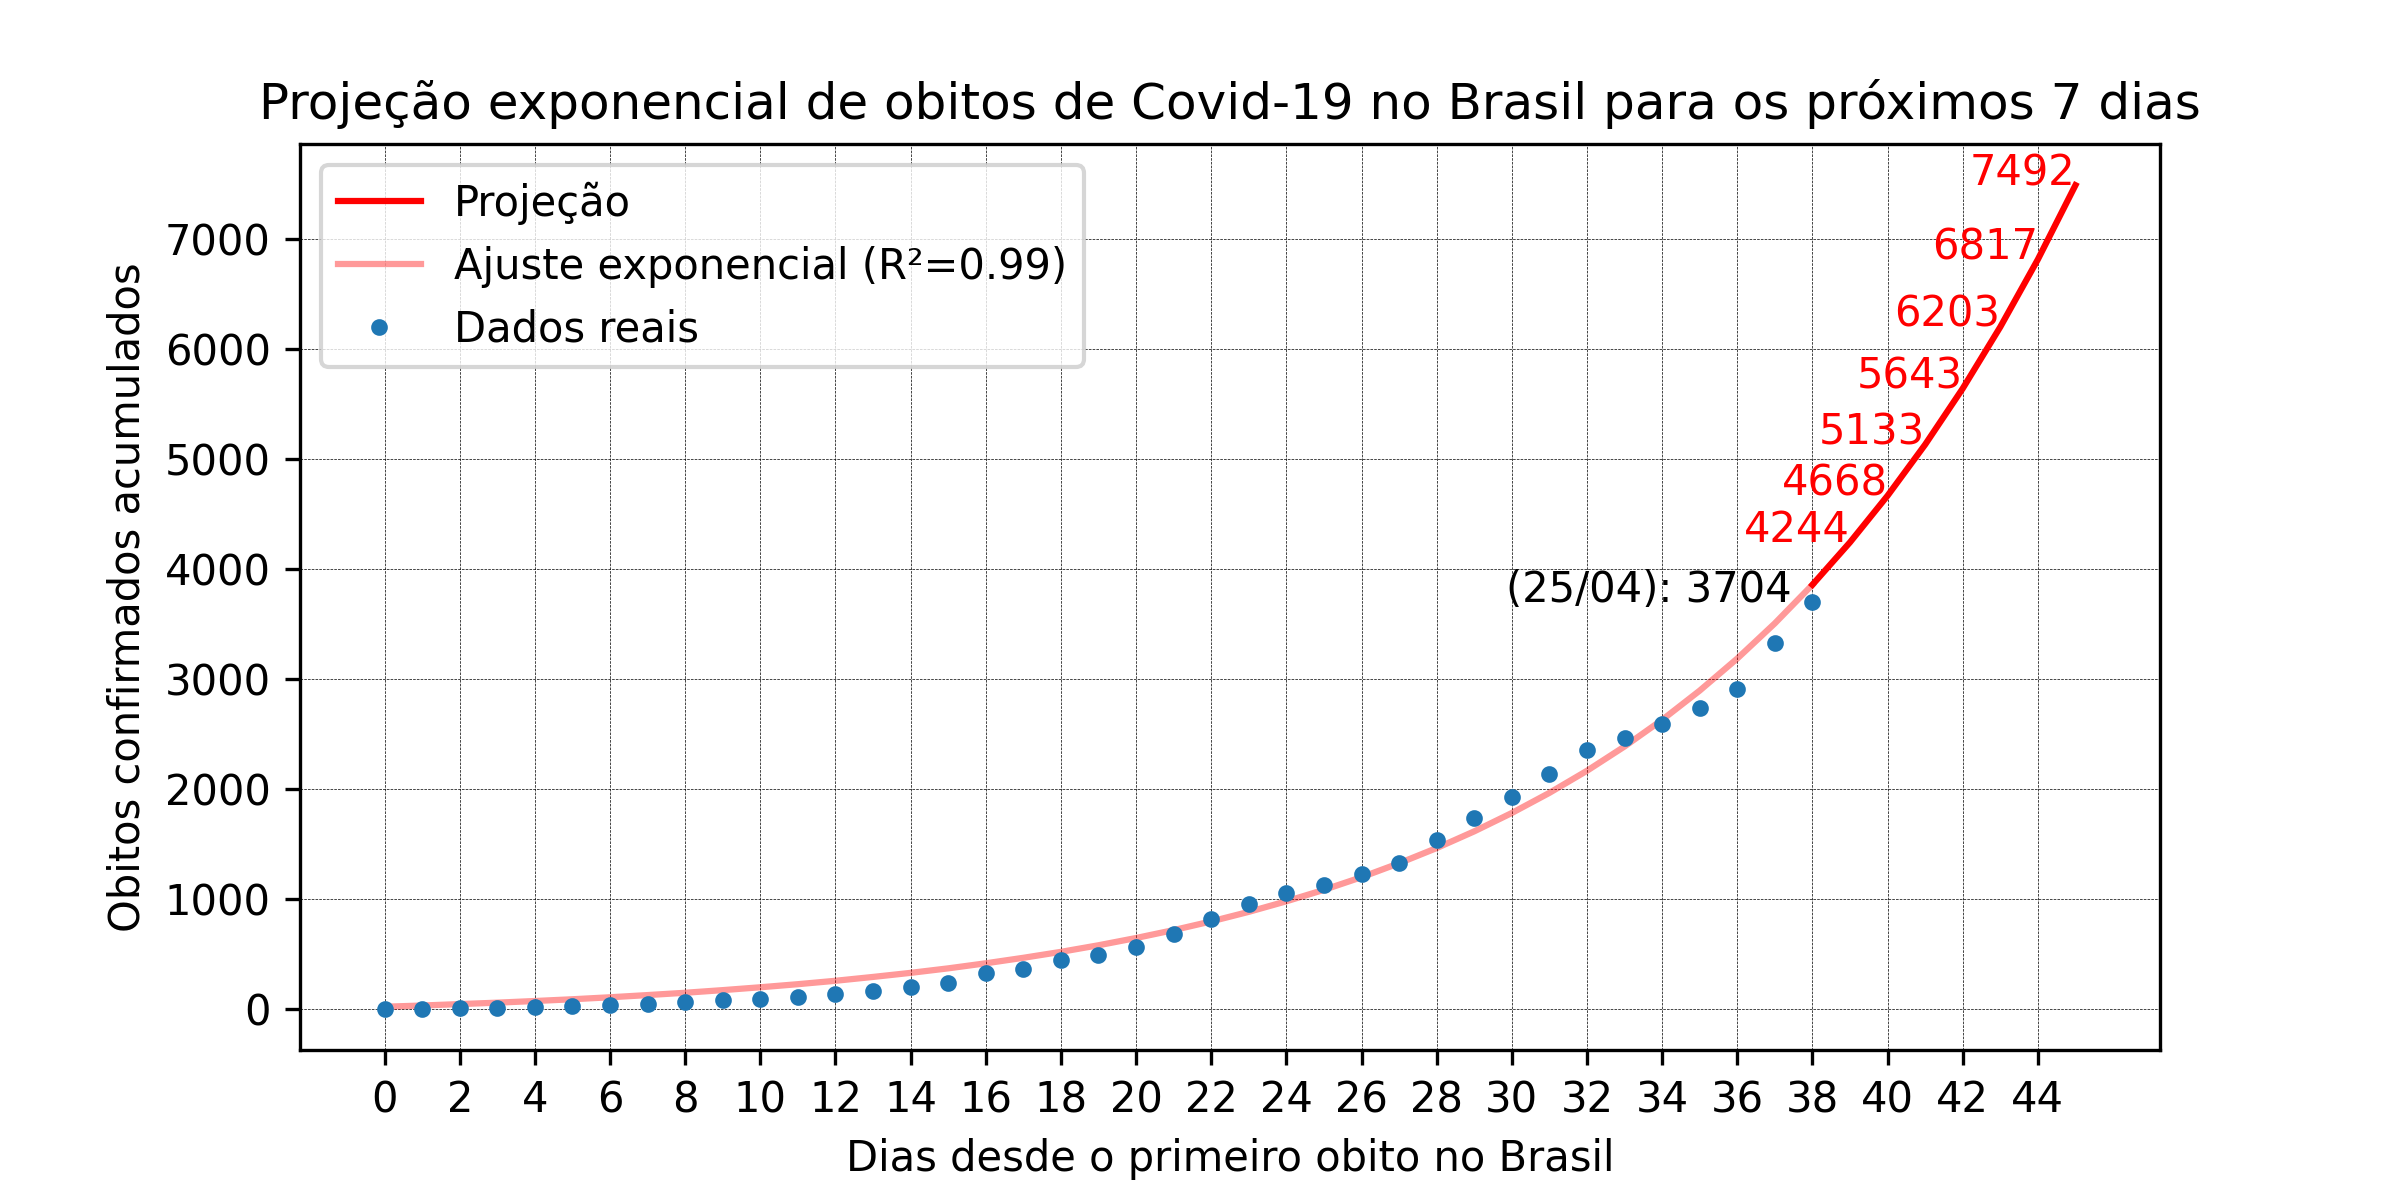

In [77]:
#hide_input
try:
    display(Image('projecao_exponencial_obitos_7_dias.png'))
except:
    pass

### Número de Casos Novos Confirmados

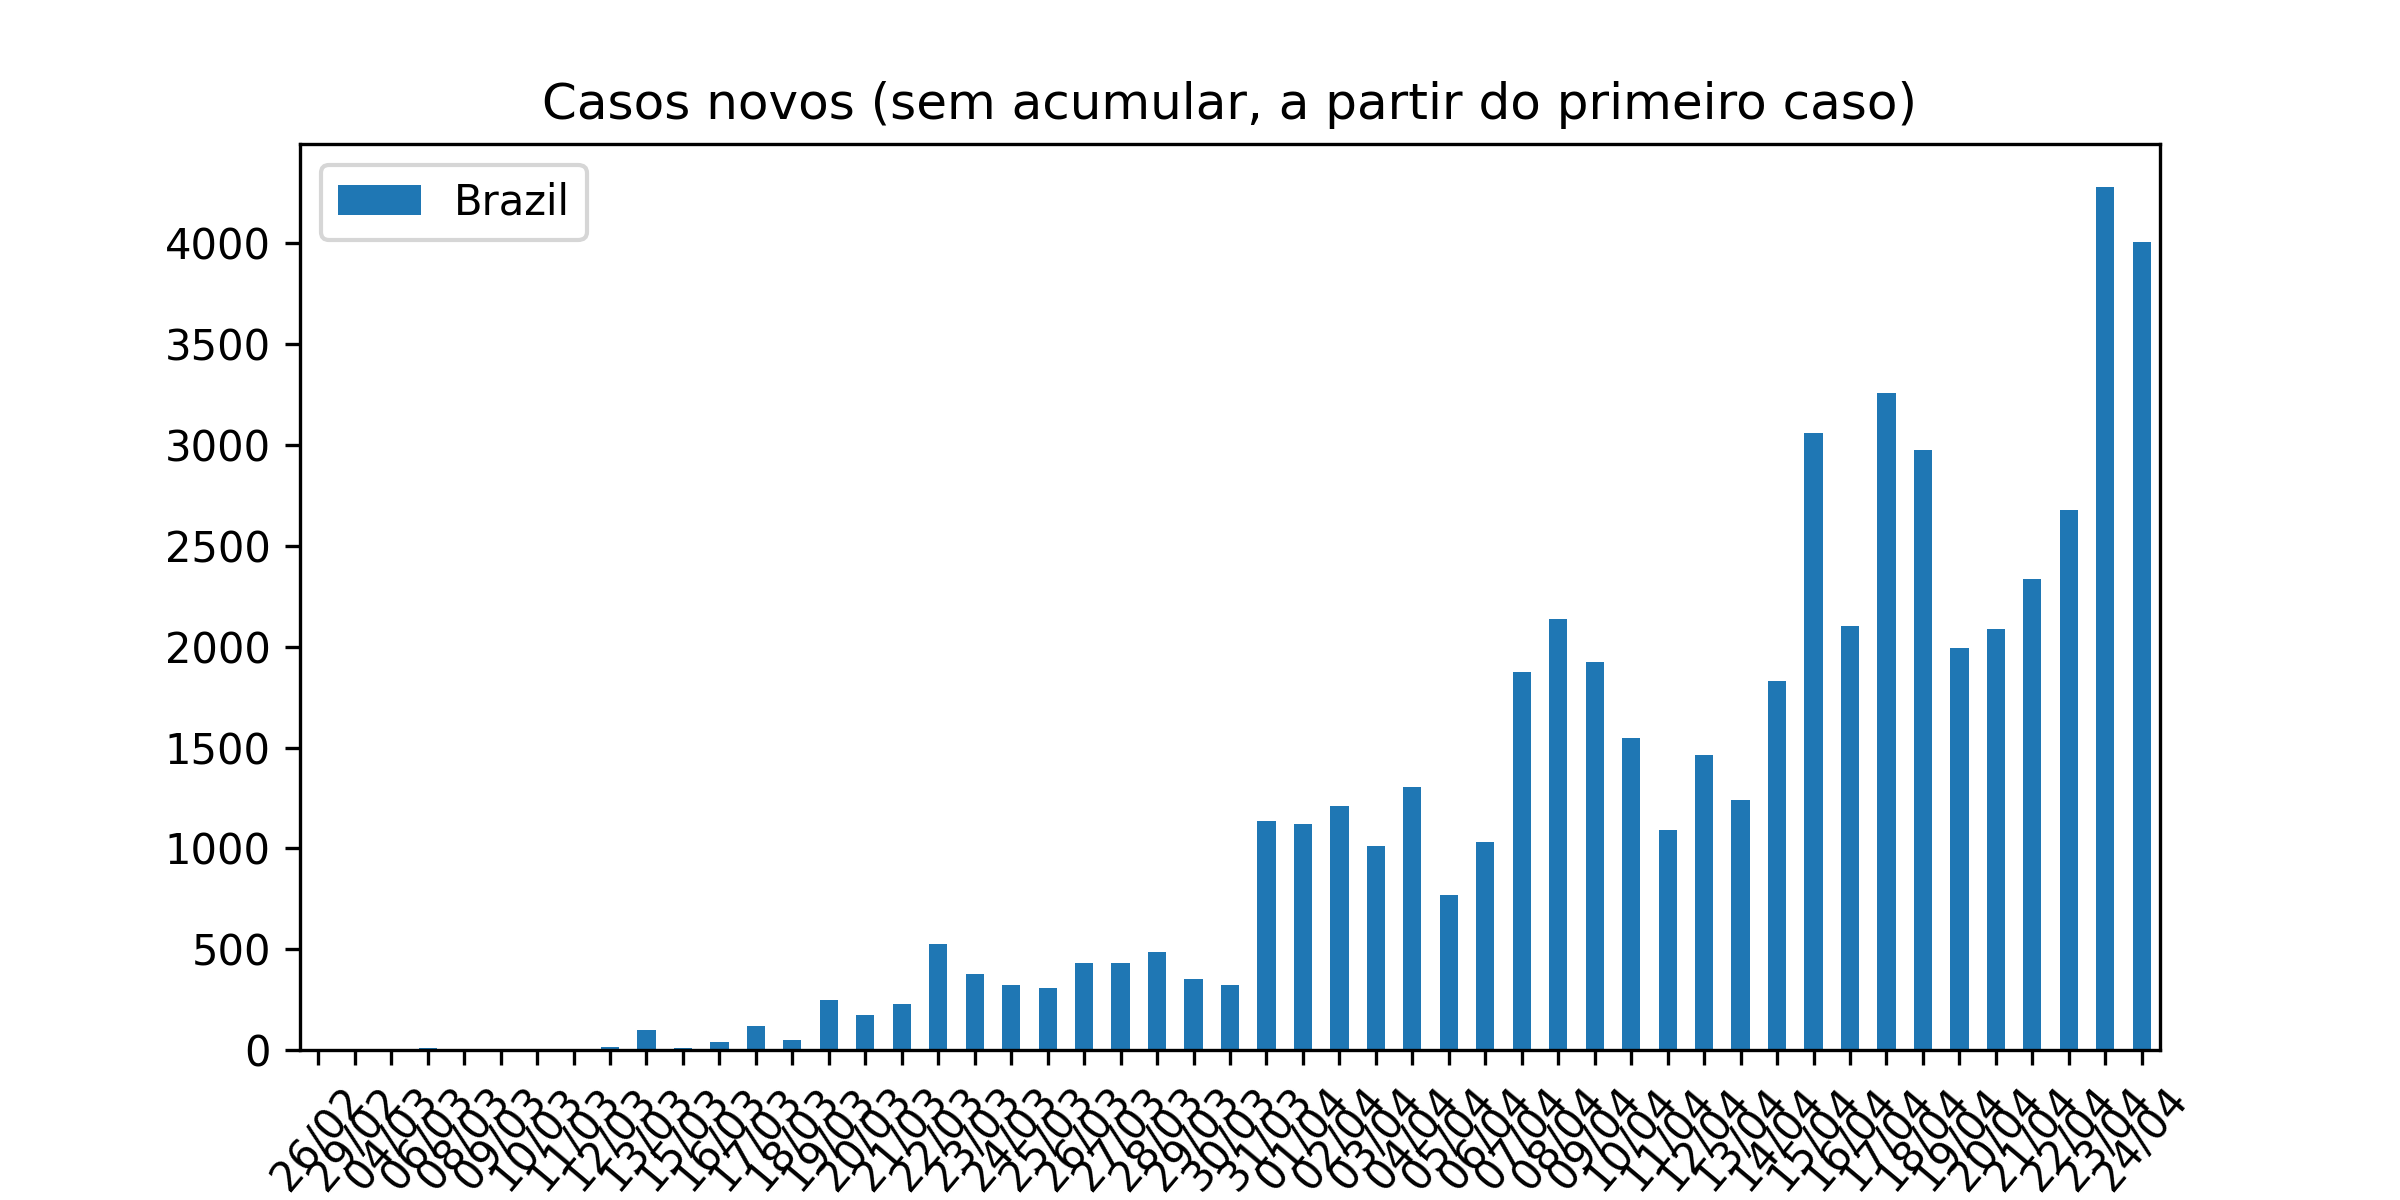

In [78]:
#hide_input
try:
    display(Image('casos_novos.png'))
except:
    pass

### Números de Óbitos Novos

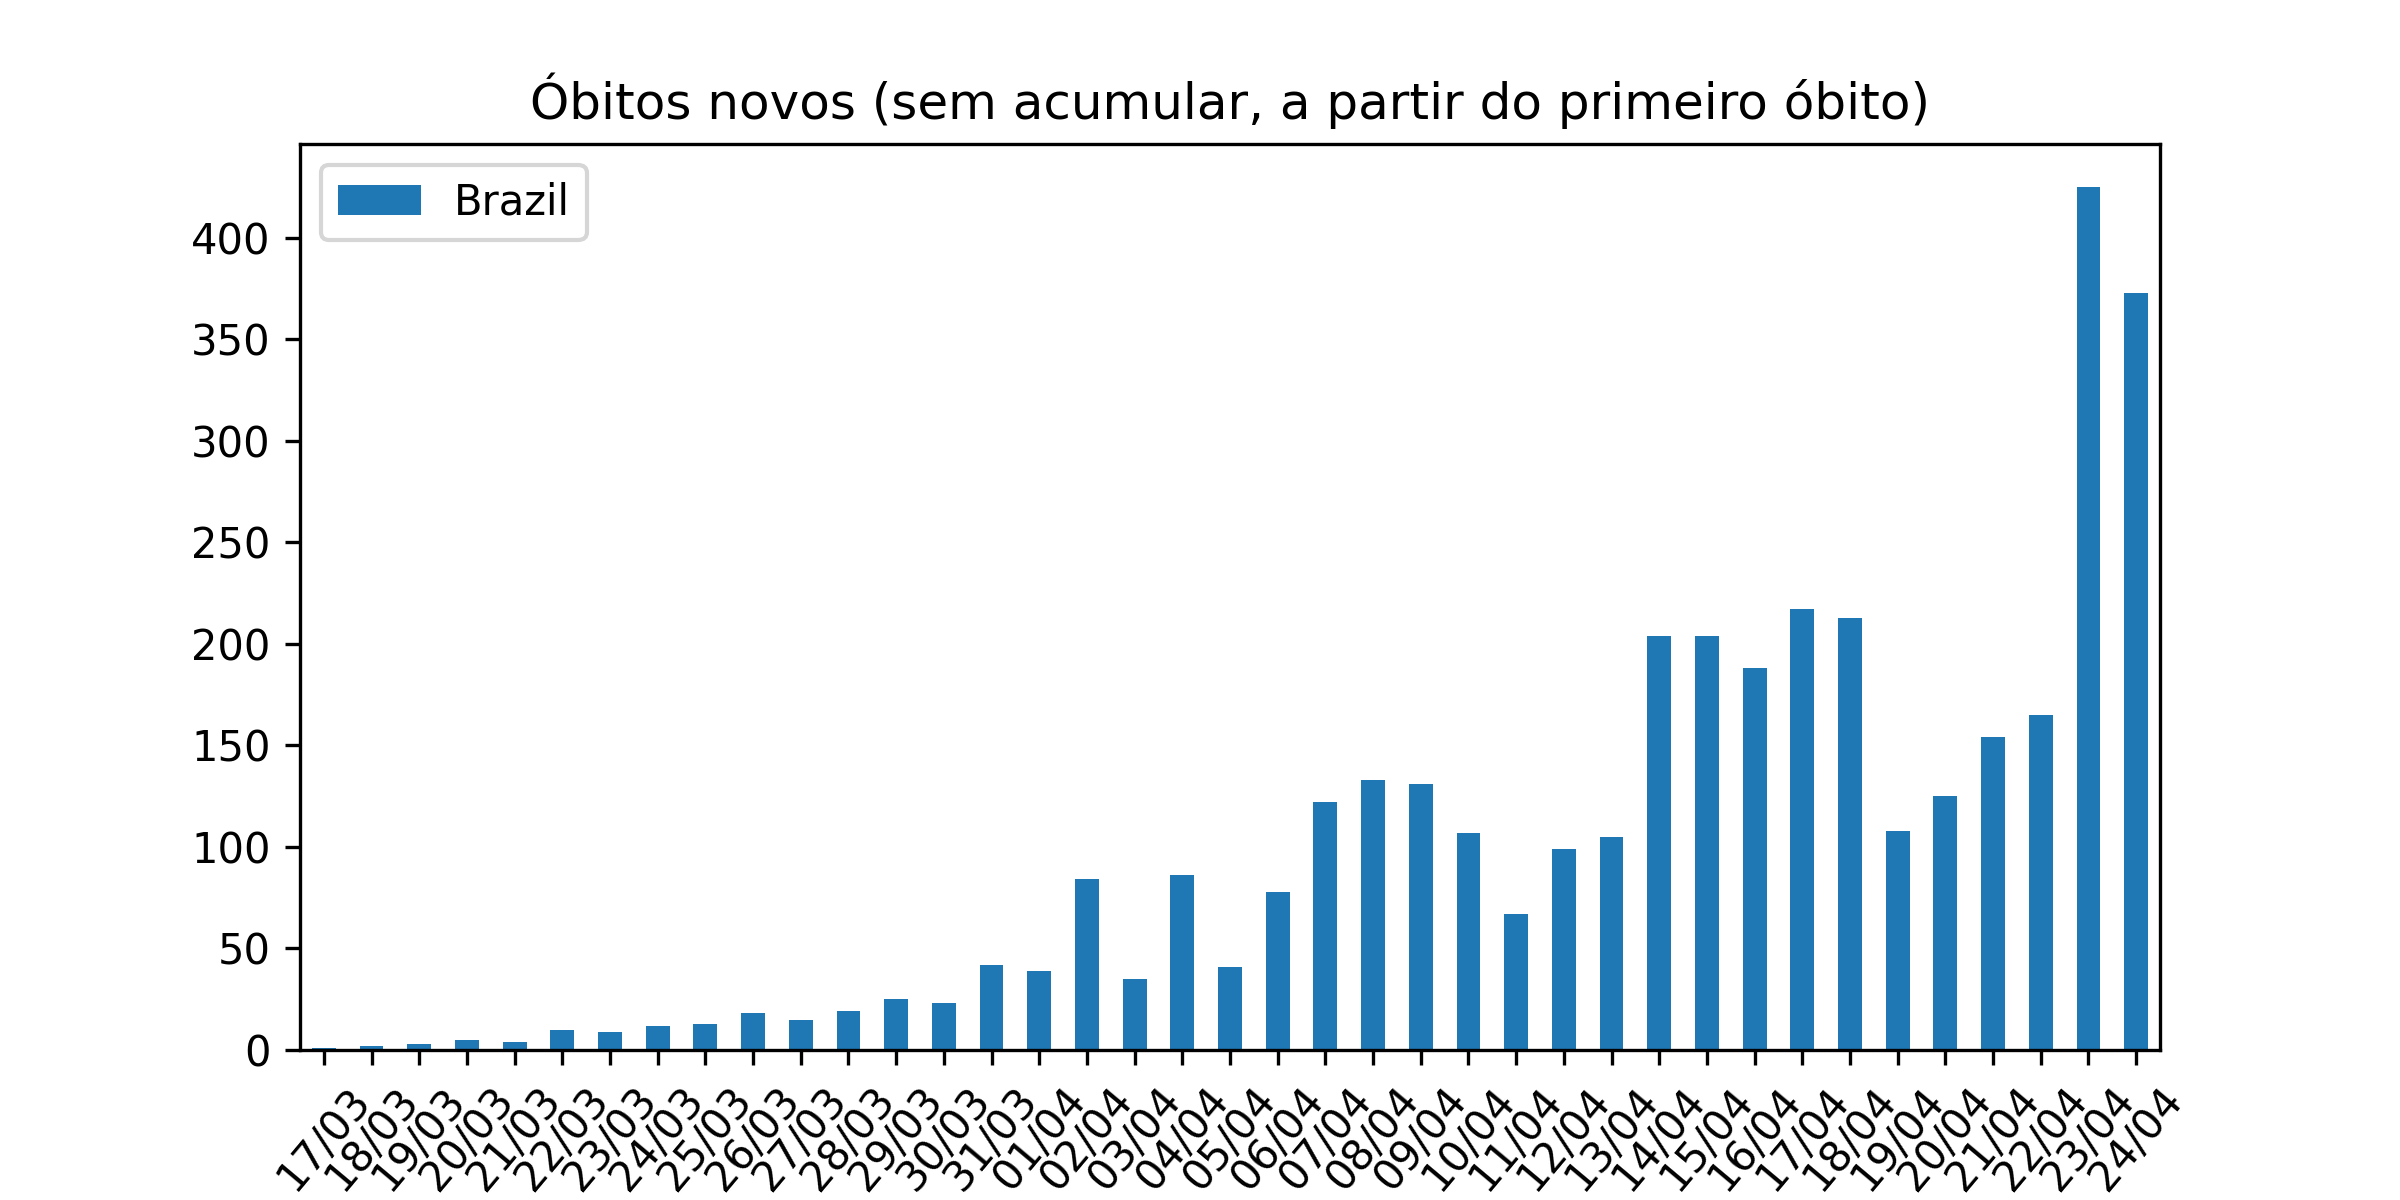

In [79]:
#hide_input
try:
    display(Image(filename='obitos_novos.png'))
except:
    pass

## Agradecimentos e Contribuições
- Ívi M. de Carvalho, D. Sc.

## (Para Programadores) Código para geração dos gráficos
> **NOTA:** O resto desse relatório está focado no desenvolvimento dos gráficos mostrados acima. Somente é relevante caso tenha interesse em Python e Data Analysis

Neste relatório vamos desenvolver em Python uma projeção que pode ser atualizada em tempo real do número de casos de Covid-19 no Brasil. Devido à sua natureza com crescimento exponencial, podemos fazer projeções de curto/médio prazo de acordo com tal tendência. É importante salientar que não existe nenhuma exponencial pura. Em algum momento haverá um ponto de inflexão (quando o número de casos começa a diminuir) e esta exponencial se tornará um sigmóide (como já é o caso da China). Portanto, como não há como prever quando ocorrerá essa inflexão, as projeções somente são úteis para curto e médio prazo. Sem mais delongas, vamos começar! Primeiramente, todas as importações que serão utilizadas:

In [80]:
#hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
#hide
!pip install -U keras

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)


In [0]:
# Todas as importações vem aqui
import numpy as np
import pandas as pd;
import matplotlib.pyplot as plt
import seaborn as sns;
from sklearn.linear_model import LinearRegression
from datetime import date

E também parâmetros:

In [0]:
FIGSIZE = (8,4)

Em seguida, vamos importar a base de dados disponibilizada pelo [repositório da John Hopkins University](https://github.com/CSSEGISandData/COVID-19). Há duas bases relevantes para nosso caso, uma com o histórico do número de casos e outro com o histório do número de mortes (ambos obtido a partir dos relatórios diários da OMS).

In [0]:
CASOS_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
MORTES_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

Ambos são urls diretas para arquivos .CSV, portanto podemos importá-los diretamente para a biblioteca Pandas do Python, sem precisar baixá-los:

In [0]:
casos = pd.read_csv(CASOS_URL)
mortes = pd.read_csv(MORTES_URL)

Vamos visualizar o cabeçalho de cada um:

In [86]:
casos.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714,784,840,906,933,996,1026,1092,1176,1279,1351
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467,475,494,518,539,548,562,584,609,634,663,678
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629,2718,2811,2910,3007,3127
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646,659,673,673,696,704,713,717,717,723,723,731
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19,19,19,19,19,24,24,24,24,25,25,25


In [87]:
mortes.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,2,4,4,4,4,4,4,4,6,6,7,7,11,14,14,15,15,18,18,21,23,25,30,30,30,33,36,36,40,42,43
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,2,2,2,2,2,4,5,5,6,8,10,10,11,15,15,16,17,20,20,21,22,22,23,23,23,23,23,24,25,26,26,26,26,26,26,27,27,27
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,4,7,9,11,15,17,17,19,21,25,26,29,31,35,44,58,86,105,130,152,173,193,205,235,256,275,293,313,326,336,348,364,367,375,384,392,402,407,415
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1,3,3,3,6,8,12,14,15,16,17,18,21,22,23,25,26,26,29,29,31,33,33,35,35,36,37,37,37,37,40
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


Como para este relatório temos interesse em apenas dados do Brasil, vamos atribuir duas novas variáveis à ambos:

In [0]:
def filter_country(df, country):
    # Filtrar pais
    df = df[df['Country/Region']==country]

    # Remover colunas iniciais, manter somente as datas
    df = df.iloc[:, 4:]

    # Transpor
    df = df.T

    # Redefinir coluna
    df.columns = [country]

    # Definir index para Datetime
    df.index = pd.to_datetime(df.index)

    return df

casos_brasil = filter_country(casos, 'Brazil')
mortes_brasil = filter_country(mortes, 'Brazil')

In [0]:
#hide
del casos, mortes

Vamos ver como ficaram os novos dataframes:

In [90]:
casos_brasil.tail()

,Brazil
2020-04-20,40743
2020-04-21,43079
2020-04-22,45757
2020-04-23,50036
2020-04-24,54043


In [91]:
mortes_brasil.tail()

,Brazil
2020-04-20,2587
2020-04-21,2741
2020-04-22,2906
2020-04-23,3331
2020-04-24,3704


Podemos facilmente também plotar tais dados para ver como estão:

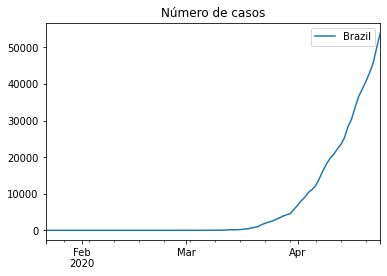

In [92]:
casos_brasil.plot(title='Número de casos');

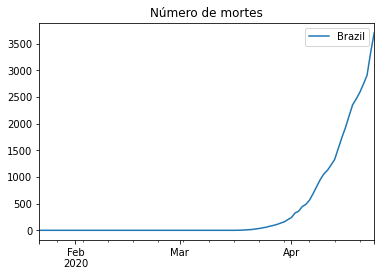

In [93]:
mortes_brasil.plot(title='Número de mortes');

Podemos conferir se o número de casos está se acelerando ou não plotando um gráfico de barras do número de casos por dia. Isso será importante para identificar a inflexão!

In [94]:
casos_novos_brasil = casos_brasil[1:]-casos_brasil[:-1].values
casos_novos_brasil.tail()

,Brazil
2020-04-20,2089
2020-04-21,2336
2020-04-22,2678
2020-04-23,4279
2020-04-24,4007


In [95]:
mortes_novas_brasil = mortes_brasil[1:]-mortes_brasil[:-1].values
mortes_novas_brasil.tail()

,Brazil
2020-04-20,125
2020-04-21,154
2020-04-22,165
2020-04-23,425
2020-04-24,373


Em seguida vamos visualizar ambos em um gráfico de barras:


In [0]:
# Funcao personalizada
def plot_bar_novos(df, title):
    df.index = df.index.strftime('%d/%m')#astype('str')
    ax = df.plot.bar(
        title=title, 
        figsize=FIGSIZE
    )
    _=plt.xticks(rotation=50)  
    return ax

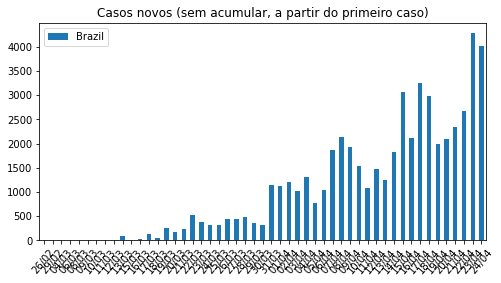

In [97]:
primeiro_caso_filtro = casos_novos_brasil.values>0
ax=plot_bar_novos(casos_novos_brasil[primeiro_caso_filtro],
    title='Casos novos (sem acumular, a partir do primeiro caso)', 
    )

In [0]:
#hide
ax.figure.savefig('casos_novos.png', dpi=300)

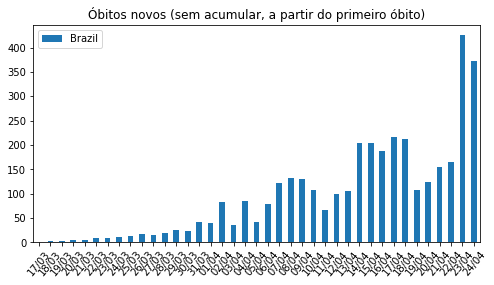

In [99]:
# Filtrar a partir do primeiro obito
primeiro_obito_filtro = mortes_novas_brasil.values>0

# Criar plot
ax=plot_bar_novos(mortes_novas_brasil[primeiro_obito_filtro],
               title='Óbitos novos (sem acumular, a partir do primeiro óbito)'
               )

In [0]:
ax.figure.savefig('obitos_novos.png', dpi=300)

In [101]:
#hide
ls

casos_novos.png                        projecao_exponencial_obitos_7_dias.png
obitos_novos.png                       sample_data/
projecao_elu_obitos_7_dias.png         scatter_matrix_primeiro_caso.png
projecao_exponencial_casos_7_dias.png  scatter_matrix_primeiro_obito.png



Vamos agora dar início à modelagem das projeções. Primeiramente, vamos fazer alguns plots em cima do log dos dados:


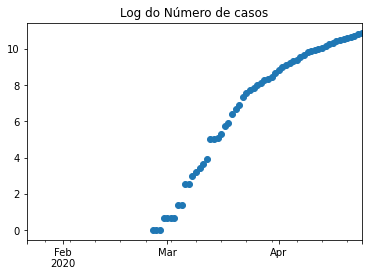

In [102]:
casos_brasil['Brazil'].apply(np.log).plot(marker='o', linestyle='', title='Log do Número de casos');

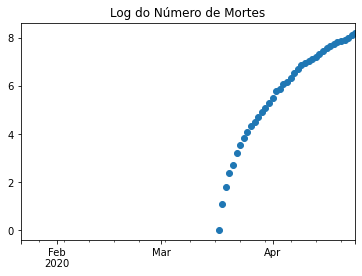

In [103]:
mortes_brasil['Brazil'].apply(np.log).plot(marker='o', linestyle='', title='Log do Número de Mortes');

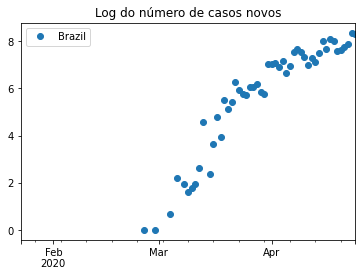

In [104]:
casos_novos_brasil.apply(np.log).plot(marker='o', linestyle='', title='Log do número de casos novos');

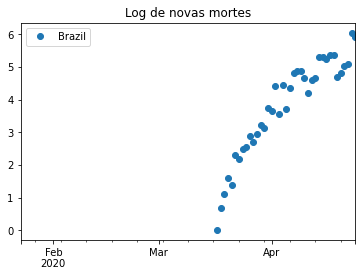

In [105]:
mortes_novas_brasil.apply(np.log).plot(marker='o', linestyle='', title='Log de novas mortes');

Todas as curvas acima não representam uma reta perfeita, o que são ótimas notícias: Significa que talvez não esteja mais seguindo uma tendência exponencial. De qualquer forma, vou usar como ponto de partida uma regressão linear, apesar de haverem ressalvas sobre o uso dela. Por simplificação, vou começar com uma projeção do número total de casos e de mortes. Primeiramente, vou juntar todos os dados em um único dataframe: 

In [106]:
brasil = pd.DataFrame({
              'Confirmados Cumulativo': casos_brasil['Brazil'].values[1:],
              'Confirmados Novos': casos_novos_brasil['Brazil'].values,
              'Mortes Cumulativa': mortes_brasil['Brazil'].values[1:],
              'Mortes Novas': mortes_novas_brasil['Brazil'].values
              })

brasil.index = casos_novos_brasil.index
brasil.tail()

,Confirmados Cumulativo,Confirmados Novos,Mortes Cumulativa,Mortes Novas
2020-04-20,40743,2089,2587,125
2020-04-21,43079,2336,2741,154
2020-04-22,45757,2678,2906,165
2020-04-23,50036,4279,3331,425
2020-04-24,54043,4007,3704,373


Também podemos criar um dataframe com o log de todos os dados:

In [107]:
brasil_log = brasil.apply(np.log1p)
brasil_log.tail()

,Confirmados Cumulativo,Confirmados Novos,Mortes Cumulativa,Mortes Novas
2020-04-20,10.615064,7.644919,7.858641,4.836282
2020-04-21,10.670814,7.756623,7.916443,5.043425
2020-04-22,10.731122,7.893199,7.974877,5.111988
2020-04-23,10.820518,8.361708,8.111328,6.054439
2020-04-24,10.897554,8.296048,8.217439,5.924256


Vamos visualizar a distribuição de cada um e também scatter plots de cada um versus o outro:

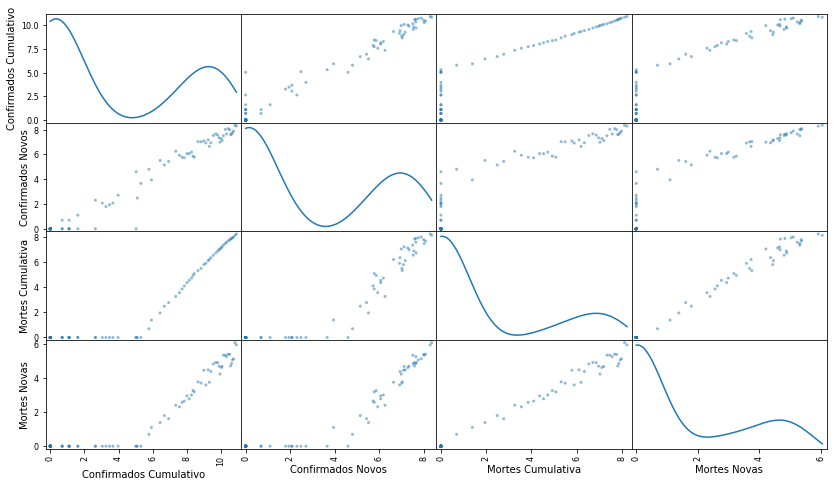

In [108]:
pd.plotting.scatter_matrix(brasil_log, figsize = (14,8), diagonal = 'kde');

O plot acima fica um pouco enviesado pois há um grande acúmulo de zeros. Vamos filtrar as datas a partir do promeiro óbito:

In [109]:
primeiro_obito = brasil_log.index[brasil_log['Mortes Cumulativa']>0][0]
primeiro_obito_filtro = brasil_log.index>=primeiro_obito
primeiro_obito

Timestamp('2020-03-17 00:00:00')

Como é uma base bastante recente, vamos também pegar o primeiro caso:

In [110]:
primeiro_caso = brasil_log.index[brasil_log['Confirmados Cumulativo']>0][0]
primeiro_caso_filtro = brasil_log.index>=primeiro_caso
primeiro_caso

Timestamp('2020-02-26 00:00:00')

Vamos repetir o scatter matrix acima a partir dos filtros que definimos:

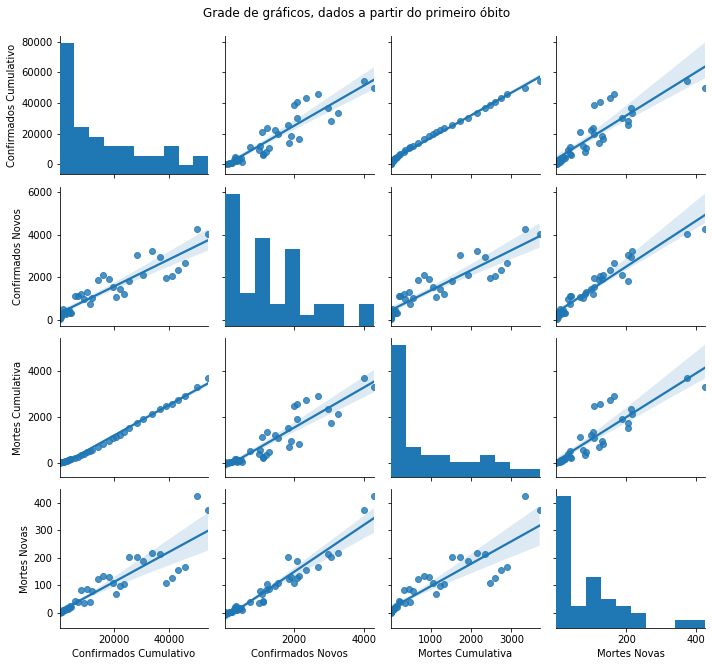

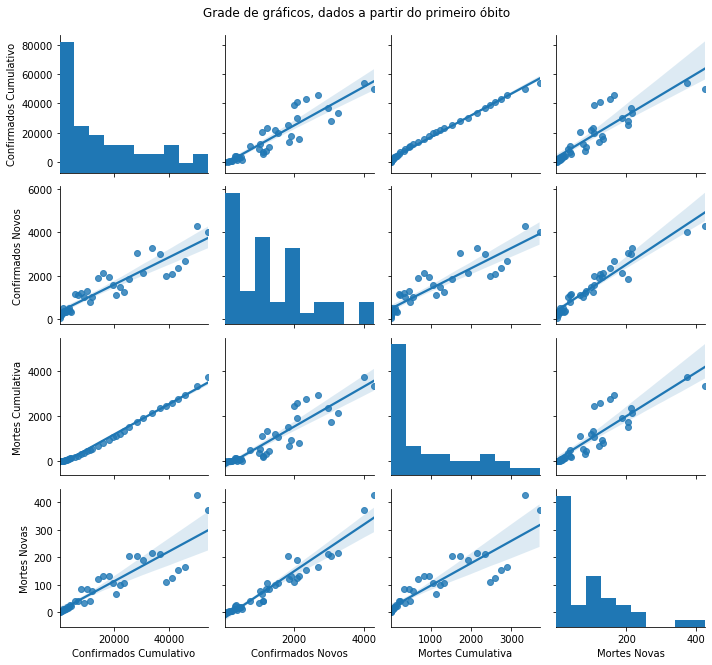

In [111]:
g = sns.pairplot(brasil[primeiro_obito_filtro], kind="reg")
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.88)
g.fig.suptitle('Grade de gráficos, dados a partir do primeiro óbito', y=0.92);

In [0]:
#hide
g.fig.savefig('scatter_matrix_primeiro_obito.png', dpi=300)

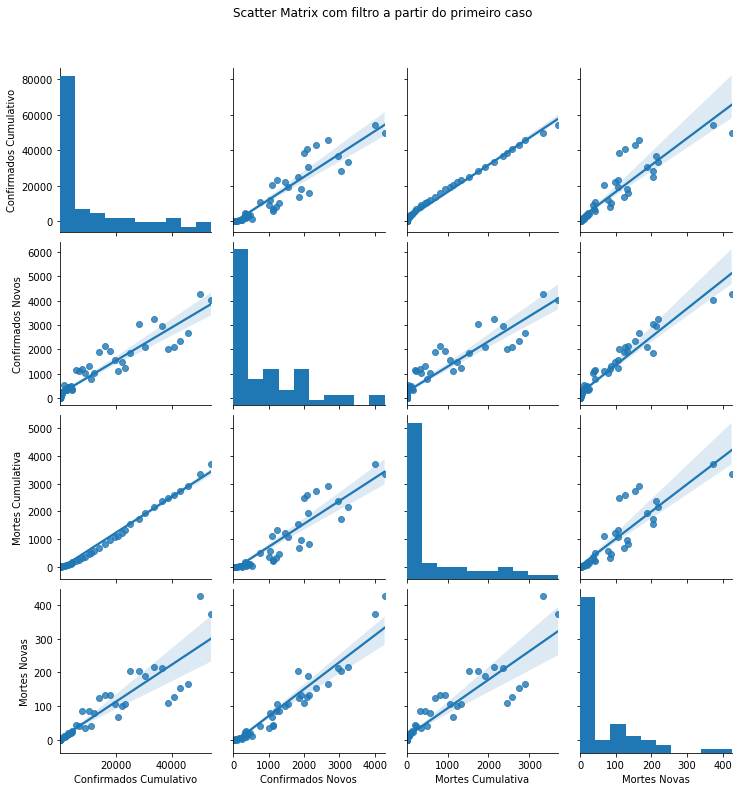

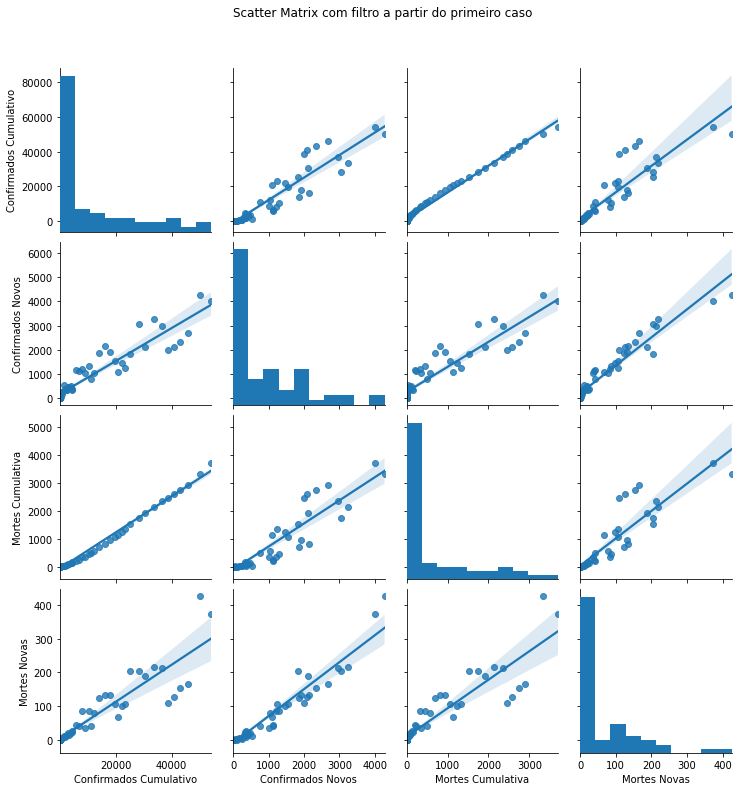

In [113]:
g = sns.pairplot(brasil[primeiro_caso_filtro], kind="reg")
g.fig.suptitle('Scatter Matrix com filtro a partir do primeiro caso', y=1.08);

In [0]:
#hide
g.fig.savefig('scatter_matrix_primeiro_caso.png', dpi=300)

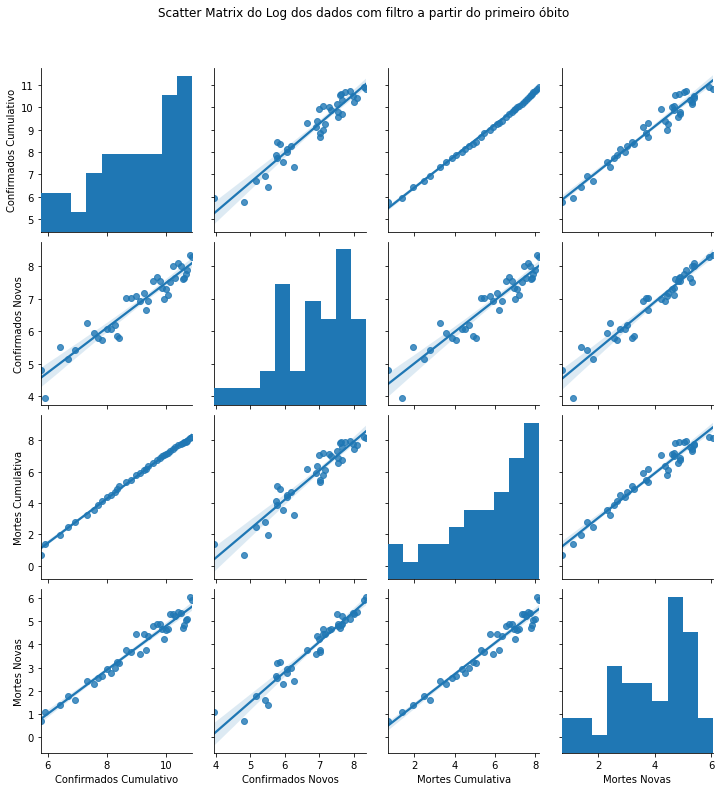

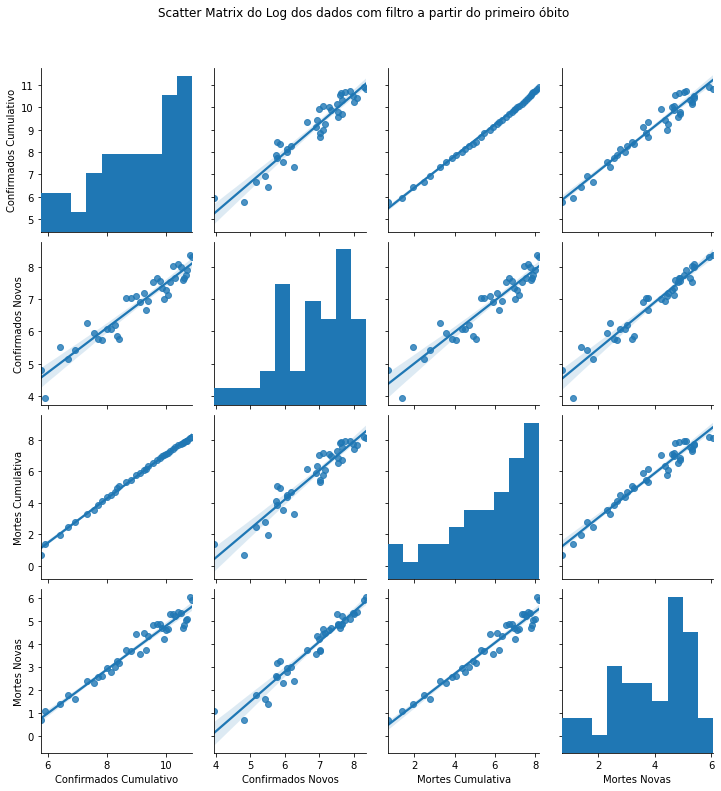

In [115]:
g = sns.pairplot(brasil_log[primeiro_obito_filtro], kind="reg")
g.fig.suptitle('Scatter Matrix do Log dos dados com filtro a partir do primeiro óbito', y=1.08);

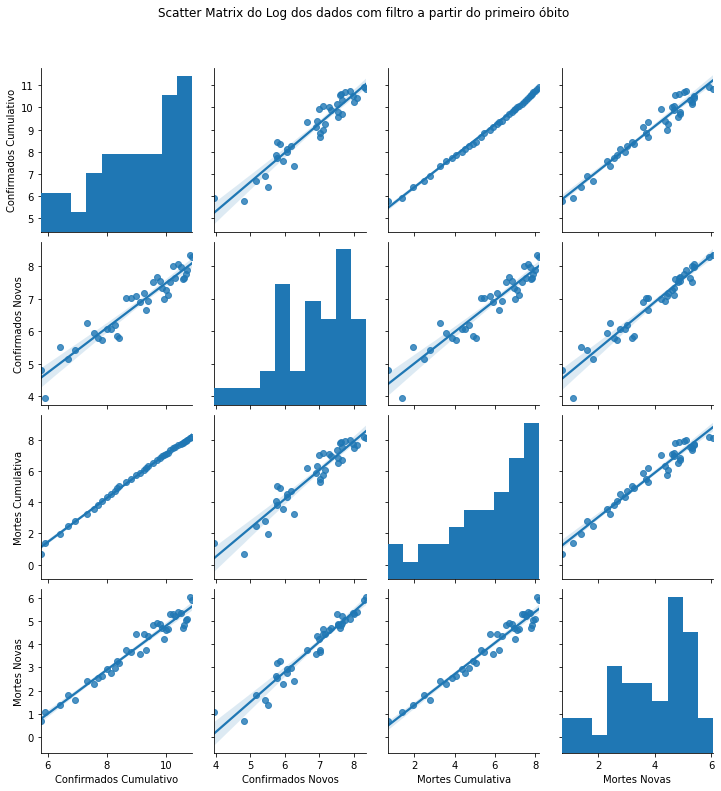

In [42]:
g = sns.pairplot(brasil_log[primeiro_obito_filtro], kind="reg")
g.fig.suptitle('Scatter Matrix do Log dos dados com filtro a partir do primeiro óbito', y=1.08);

Os plots acima, talvez pareçam informação irrelevante, mas o fiz para ter uma ideia sobre a distribuição dos dados e se há alguma distribuição normal em algum caso, que justificaria o uso do desvio padrão (uma vez que o mesmo é em relação à distribuição normal). De qualquer forma, para manter as coisas simples inicialmente, vou manter meu plano inicial de criar uma projeção do número de casos incluindo o intervalo do desvio padrão. Então vamos começar pegando o as estatísticas filtrando a partir do primeiro caso:

In [0]:
std = brasil_log[primeiro_caso_filtro].std()

Visualizar um plot da tendência que vamos modelar:

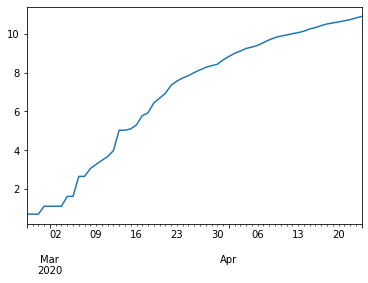

In [44]:
brasil_log[primeiro_caso_filtro]['Confirmados Cumulativo'].plot()

Em seguida ajustar uma regressão linear em cima do log:


In [0]:
def fitar(x, y):
    lr = LinearRegression()
    lr.fit(x,y)
    return lr

x = np.arange(sum(primeiro_caso_filtro)).reshape(-1,1)
y = brasil_log[primeiro_caso_filtro]['Confirmados Cumulativo'].values
lr_casos = fitar(x, y)

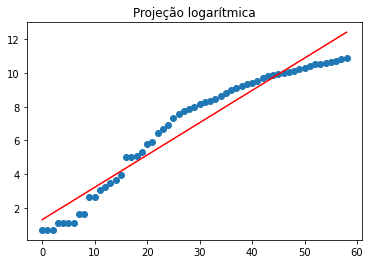

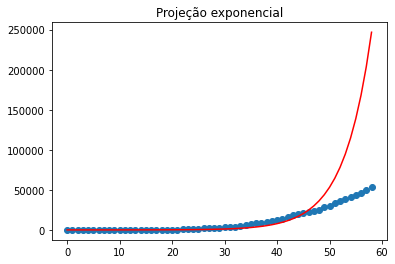

In [46]:
def projetar(lr, x, y, plot=True):
    y_pred = lr.predict(x)
    if plot:
        plt.scatter(x, y)
        plt.plot(y_pred, 'r')
        plt.title("Projeção logarítmica")
        plt.show()

        plt.scatter(x, np.expm1(y))
        plt.plot(np.expm1(y_pred), 'r')
        plt.title("Projeção exponencial")
        plt.show()
    return y_pred

y_pred = projetar(lr_casos, x, y)

A projeção acima não ficou boa, vamos testar suavizar com um exponential moving average:

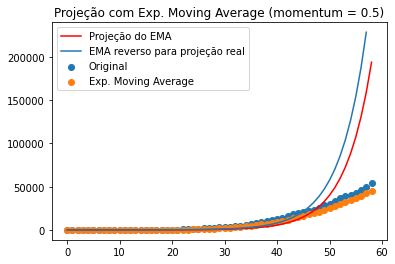

In [47]:
def generate_moving_average(data, mom=0.7):
    MOM = 0.7
    rolling_mean = [data[0]]

    for d in data[1:]:
        rolling_mean.append(rolling_mean[-1]*MOM + (1-MOM)*d)

    return np.array(rolling_mean)

def fitar_projetar(x, y, mom=None):
    if mom is not None:
        y_old = y
        y = generate_moving_average(y)

    lr = fitar(x, y)
    y_pred = projetar(lr, x, y, plot=not mom) # Plota se mom for nulo

    if mom is not None:
        y_pred_exp = np.expm1(y_pred)
        reversed_mv = [(rm-rm_*mom)/(1-mom) 
                       for rm, rm_ in zip(y_pred_exp[1:], y_pred_exp[:-1])]

        plt.scatter(x, np.expm1(y_old), label="Original")
        plt.scatter(x, np.expm1(y), label="Exp. Moving Average")
        plt.plot(y_pred_exp, 'r', label="Projeção do EMA")
        plt.plot(reversed_mv, label="EMA reverso para projeção real")
        plt.legend()
        plt.title(f"Projeção com Exp. Moving Average (momentum = {mom})")
        plt.show()
    return y_pred

y_pred = fitar_projetar(x, y, mom=0.5)

Também não ficou muito boa. Um dos motivos de estas funções não estarem se saindo bem é que o erro está sendo inferido na escala logarítmica, ou seja, enquanto estamos na escala logarítmica, o erro em termos absolutos é pequeno, no entanto, quando passamos à escala normal, o erro aumenta consideravelmente. Parra corrigir isso, precisamos ajustar uma função exponencial diretamente sem realizar a transformação logarítmica. Precisamos de uma função de custo que infira o erro diretamente da exponencial. Podemos fazer isso com o auxílio de otimizadores de redes neurais. Vamos também aproveitar para ajustar uma sigmóide. E aqui um detalhe: para quem é de machine learning, as boas práticas de seleção de modelos não se aplicam aqui (por exemplo, divisão treinamento e teste). Como os modelos a serem ajustados são bastante simples, não há a necessidade de reservar um conjunto de validação/teste.

In [48]:
# Creating a model
from keras.models import Sequential;
from keras.layers import Dense
from keras import backend as K
from keras.optimizers import Adam
from keras.activations import sigmoid, elu

def get_keras_model(lr=0.001, activation='exp'):
    if activation=='exp':
        def activ_func(x):
            return K.exp(x) - 1
    elif activation=='sigm':
        activ_func = sigmoid
    elif activation=='elu':
        activ_func = elu

    # Usage
    model = Sequential();
    model.add(Dense(1, input_dim=1, activation=activ_func))
    model.compile(optimizer=Adam(lr=lr), loss='mean_squared_error')
    return model

Using TensorFlow backend.


In [0]:
# Definir entrada e saida
x = np.arange(sum(primeiro_caso_filtro)).reshape(-1,1)
y = brasil[primeiro_caso_filtro]['Confirmados Cumulativo'].values

In [0]:
# Preparar dados
def preparar_dados(x, y):
    x_mean = x.mean()
    x_std = x.std()
    y_mean = y.mean()
    y_std = y.std()

    x_prep = (x-x_mean)/x_std
    y_prep = (y-y_mean)/y_std
    return x_prep, y_prep

x_prep, y_prep = preparar_dados(x, y)

In [0]:
#hide_output
model = get_keras_model(lr=0.1)
model.fit(x_prep, y_prep, epochs=100, verbose=0);

In [0]:
from sklearn.metrics import r2_score

In [0]:
def projetar_keras(model, x, y, days_ahead=0, plot=True, 
                   model_func="exponencial", 
                   tipo='caso', exibir_pontos=False,
                   anotar_dados_reais=True,
                   dados_reais_step=2):
    title = f'Projeção {model_func} de {tipo}s de Covid-19 no Brasil' + f' para os próximos {days_ahead} dias'
    hoje = date.today()
    hoje = hoje.strftime("%d/%m")
    x_mean = x.mean()
    x_std = x.std()
    y_mean = y.mean()
    y_std = y.std()

    n_days = len(x)
    x_proj = np.arange(n_days+days_ahead).reshape(-1,1)

    x_prep = (x_proj-x_mean)/x_std
    y_prep = (y-y_mean)/y_std

    y_pred = model.predict(x_prep)
    y_pred = y_pred*y_std + y_mean #Reverse y_pred back
    y_pred = y_pred.astype(int)
    y_pred = np.clip(y_pred, 0, None)
    y_pred = y_pred.squeeze()

    #print(y)
    #print(y_pred)

    r2 = r2_score(y, y_pred[:-days_ahead])

    if plot:
        fig = plt.figure(figsize=FIGSIZE)
        # Plotar projeção
        plt.plot(x_proj[-days_ahead-1:], y_pred[-days_ahead-1:], '-', 
                 color='red', label='Projeção')
        
        # Plotar função
        if exibir_pontos:
            plt.plot(x_proj[:-days_ahead], y_pred[:-days_ahead], '-', color='red', 
                     label=f'Ajuste {model_func} (R²={r2:.2f})', alpha=0.4)
        #plt.scatter(x, y, label='Dados reais', color='orange')
        plt.plot(y, '.', label='Dados reais')
        plt.title(title)
        for x_anot, y_anot in zip(x_proj[-days_ahead:], y_pred[-days_ahead:]):
            plt.annotate(y_anot, (x_anot, y_anot), ha='right', color='red')
        plt.annotate(f'({hoje}): {y[-1]}', (x[-1], y[-1]), ha='right',
                     color='black',
                     textcoords="offset points",
                     xytext=(-5,0))
        if anotar_dados_reais:
            for x_anot, y_anot in zip(x[:-1:dados_reais_step], y[:-1:dados_reais_step]):
                plt.annotate(y_anot, (x_anot, y_anot), ha='right', 
                            color='midnightblue',
                            textcoords="offset points",
                            xytext=(-5,3)
                            )
        
        plt.grid(color='black', linestyle='--', linewidth=0.17)
        plt.legend()
        plt.xlabel(f"Dias desde o primeiro {tipo} no Brasil")
        plt.ylabel(f'{tipo.capitalize()}s confirmados acumulados')
        plt.xticks(x_proj[::2])
        plt.show()
    return y_pred, fig

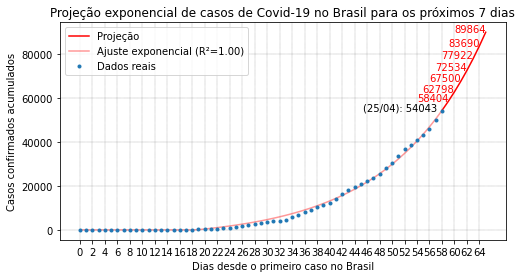

In [54]:
y_pred, fig = projetar_keras(model, x, y, days_ahead=7, 
                             exibir_pontos=True, 
                             anotar_dados_reais=False,
                             dados_reais_step=3)

In [0]:
#hide
fig.savefig('projecao_exponencial_casos_7_dias.png', dpi=300)

Por curiosidade, vamos testar ajustar um sigmóide:

In [0]:
#hide
#model = get_keras_model(activation='sigm')
#lr_finder = LRFinder(min_lr=1e-4, max_lr=10)
#model.fit(x_prep, y_prep, batch_size=1, callbacks=[lr_finder], epochs=4)

In [0]:
#hide_output
model = get_keras_model(lr=1, activation='sigm')
model.fit(x_prep, y_prep, epochs=100, verbose=0);

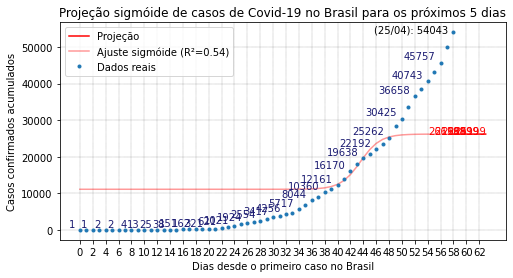

In [58]:
y_pred, fig = projetar_keras(model, x, y, days_ahead=5, model_func='sigmóide', exibir_pontos=True)

Bem distante do esperado :) Vamos testar também o ELU:

In [0]:
#hide_output
model = get_keras_model(lr=0.1, activation='elu')
model.fit(x_prep, y_prep, epochs=100, verbose=0);

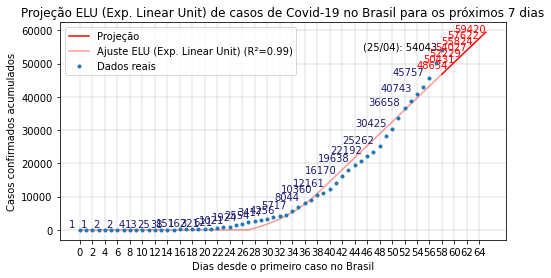

In [60]:
y_pred, fig = projetar_keras(model, x, y, days_ahead=7, model_func="ELU (Exp. Linear Unit)", exibir_pontos=True)

In [0]:
#hide
#fig.savefig('projecao_elu_casos_7_dias.png')

Um pouco melhor, mas neste caso com tendência linear. Vamos também replicar estes dois últimos para o número de óbitos. 

In [0]:
# Definir entrada e saida
x = np.arange(sum(primeiro_obito_filtro)).reshape(-1,1)
y = brasil[primeiro_obito_filtro]['Mortes Cumulativa'].values

x_prep, y_prep = preparar_dados(x, y)

In [0]:
#hide_output
model = get_keras_model(lr=0.1, activation='exp')
model.fit(x_prep, y_prep, epochs=100, verbose=0);

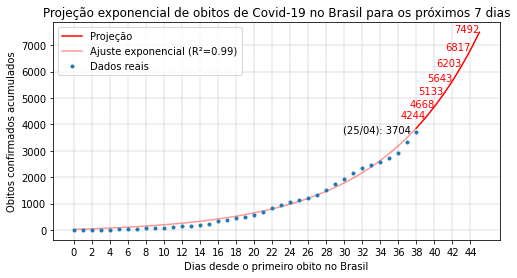

In [64]:
y_pred, fig = projetar_keras(model, x, y, days_ahead=7, model_func="exponencial", 
                             tipo='obito',
                             exibir_pontos=True, 
                             anotar_dados_reais=False,
                             dados_reais_step=3)

In [0]:
#hide
fig.savefig('projecao_exponencial_obitos_7_dias.png', dpi=300)

In [0]:
#hide_output
model = get_keras_model(lr=0.1, activation='elu')
model.fit(x_prep, y_prep, epochs=100, verbose=0);

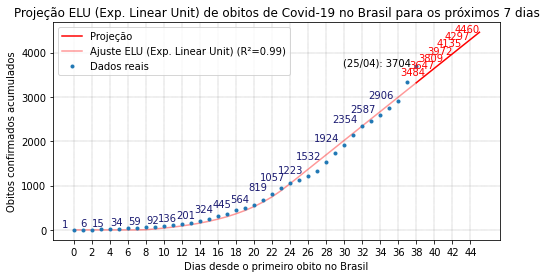

In [67]:
y_pred, fig = projetar_keras(model, x, y, 
                             days_ahead=7, 
                             model_func="ELU (Exp. Linear Unit)", 
                             tipo='obito', 
                             exibir_pontos=True)

In [0]:
#hide
fig.savefig('projecao_elu_obitos_7_dias.png', dpi=300)

In [69]:
#hide
"""
### Extrapolação do Número de Casos
O gráfico abaixo representa uma estimativa simples da quantidade de casos 
atualmente no Brasil. Uma vez que a baixa quantidade de testes tem levado os 
números a uma subnotificação, o cálculo foi realizado com base no número de 
óbitos registrados por COVID-19 no Brasil e na taxa de letalidade de países como 
a Alemanha e a Coréia do Sul, países que tem testado massivamente sua população. 
Desse modo os números são os seguintes:
"""

'\n### Extrapolação do Número de Casos\nO gráfico abaixo representa uma estimativa simples da quantidade de casos \natualmente no Brasil. Uma vez que a baixa quantidade de testes tem levado os \nnúmeros a uma subnotificação, o cálculo foi realizado com base no número de \nóbitos registrados por COVID-19 no Brasil e na taxa de letalidade de países como \na Alemanha e a Coréia do Sul, países que tem testado massivamente sua população. \nDesse modo os números são os seguintes:\n'

In [0]:
#hide
model_obitos = get_keras_model(lr=0.1, activation='exp')
model_obitos.fit(x_prep, y_prep, epochs=100, verbose=0);

In [0]:
#hide
x = np.arange(sum(primeiro_caso_filtro)).reshape(-1,1)
y = brasil[primeiro_caso_filtro]['Confirmados Cumulativo'].values
x_casos, y_casos = preparar_dados(x, y)

In [0]:
#hide
model_casos = get_keras_model(lr=0.1)
model_casos.fit(x_casos, y_casos, epochs=100, verbose=0);

In [0]:
#hide
import matplotlib
matplotlib.rcParams['axes.formatter.useoffset'] = False
y_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
ax.yaxis.set_major_formatter(y_formatter)
def extrapolar_casos(model, x, y, days_ahead=0, plot=True, 
                   model_func="exponencial", 
                   tipo='caso', exibir_pontos=False,
                   anotar_dados_reais=True,
                   dados_reais_step=2,
                   mortalidade_alemanha=0.013,
                   mortalidade_coreia=0.01
                   ):
    title = f'Projeção {model_func} de {tipo}s de Covid-19 no Brasil' + f' para os próximos {days_ahead} dias'
    hoje = date.today()
    hoje = hoje.strftime("%d/%m")
    x_mean = x.mean()
    x_std = x.std()
    y_mean = y.mean()
    y_std = y.std()

    n_days = len(x)
    x_proj = np.arange(n_days+days_ahead).reshape(-1,1)

    x_prep = (x_proj-x_mean)/x_std
    y_prep = (y-y_mean)/y_std

    y_pred = model.predict(x_prep)
    y_pred = y_pred*y_std + y_mean #Reverse y_pred back
    y_pred = y_pred.astype(int)
    y_pred = np.clip(y_pred, 0, None)
    y_pred = y_pred.squeeze()

    #print(y)
    #print(y_pred)

    r2 = r2_score(y, y_pred[:-days_ahead])

    if plot:
        fig = plt.figure(figsize=FIGSIZE)
        
        # Plotar projeção
        plt.plot(x_proj[-days_ahead-1:], y_pred[-days_ahead-1:], '-', 
                 color='red', label='Projeção')
        
        # Plotar função
        if exibir_pontos:
            plt.plot(x_proj[:-days_ahead], y_pred[:-days_ahead], '-', color='red', 
                     label=f'Ajuste {model_func} (R²={r2:.2f})', alpha=0.4)
        #plt.scatter(x, y, label='Dados reais', color='orange')
        plt.plot(y, '.', label='Dados reais')
        plt.title(title)
        for x_anot, y_anot in zip(x_proj[-days_ahead:], y_pred[-days_ahead:]):
            plt.annotate(y_anot, (x_anot, y_anot), ha='right', color='red')
        plt.annotate(f'({hoje}): {y[-1]}', (x[-1], y[-1]), ha='right',
                     color='black',
                     textcoords="offset points",
                     xytext=(-5,0))
        if anotar_dados_reais:
            for x_anot, y_anot in zip(x[:-1:dados_reais_step], y[:-1:dados_reais_step]):
                plt.annotate(y_anot, (x_anot, y_anot), ha='right', 
                            color='midnightblue',
                            textcoords="offset points",
                            xytext=(-5,3)
                            )
        plt.plot((y_pred/mortalidade_alemanha).astype(int), label='Extrapolação Alemanha')
        plt.grid(color='black', linestyle='--', linewidth=0.17)
        plt.legend()
        plt.xlabel(f"Dias desde o primeiro {tipo} no Brasil")
        plt.ylabel(f'{tipo.capitalize()}s confirmados acumulados')
        plt.xticks(x_proj[::2])
        
        ax = plt.gca()
        #a#x.ticklabel_format(useOffset=False)
        ax.get_yaxis().get_major_formatter().set_useOffset(False)

        plt.show()
    return y_pred, fig

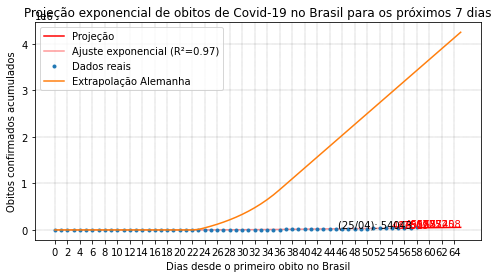

In [74]:
#hide
y_pred, fig = extrapolar_casos(model, x, y, days_ahead=7, model_func="exponencial", 
                             tipo='obito',
                             exibir_pontos=True, 
                             anotar_dados_reais=False,
                             dados_reais_step=3)